<a href="https://colab.research.google.com/github/TroyWorkPublic/tibaml0922/blob/main/VGG%E9%81%B7%E7%A7%BB%E5%AD%B8%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **環境**

In [ ]:
!apt-get install python3.6
!cp -r /usr/local/lib/python3.7/dist-packages /usr/local/lib/python3.6/

In [ ]:
!wget https://bootstrap.pypa.io/get-pip.py
!sudo python3.6 get-pip.py

In [27]:
import sys
_ = (sys.path.append("/usr/local/lib/python3.6/"))

In [ ]:
!pip -V
!python3 -V

In [29]:
!pip install keras==2.2.4

     |████████████████████████████████| 312 kB 10.5 MB/s            
     |████████████████████████████████| 50 kB 7.2 MB/s             
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires keras~=2.6, but you have keras 2.2.4 which is incompatible.


In [ ]:
!pip list





> 
# **main**



In [9]:
import zipfile
f = zipfile.ZipFile("/content/drive/MyDrive/train.zip")
f.extractall()

In [ ]:
import glob
import pandas as pd
dogs = glob.glob("train/dog.*")
cats = glob.glob("train/cat.*")
df = pd.DataFrame({
    "path":dogs + cats,
    "ans":[0] * len(dogs) + [1] * len(cats)
})
df

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
for l in cnn.layers:
    l.trainable = False
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model = Sequential(cnn.layers + layers)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [12]:
# y: 做one-hot encoding很耗費ram, 直接使用Sparse省RAM又方便
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

p = df["path"]
idx = random.randint(0, len(p)-1)
img = Image.open(p[idx]).resize((224, 224)).convert("RGB")
img_np = np.array(img)
img_np_pre = preprocess_input(img_np)
print(img_np_pre)
plt.imshow(img)

In [35]:
x = np.array(df["path"])
y = np.array(df["ans"])

In [17]:
def data_generator(x, y, batch_size=20):
    while True:
        idx = np.random.randint(0, len(x), size=batch_size)
        x_batch, y_batch = x[idx], y[idx]
        x_final = []
        for path in x_batch:
            img = Image.open(path).resize((224, 224)).convert("RGB")
            img_pre = preprocess_input(np.array(img))
            x_final.append(img_pre)
        x_final = np.array(x_final)
        y_batch = np.array(y_batch)
        yield (x_final, y_batch)
gen = data_generator(x, y)
x_gen, y_gen = gen.__next__()
print(x_gen.shape)
print(y_gen.shape)
# print(x_gen)
# print(y_gen)

(20, 224, 224, 3)
(20,)


In [36]:
from sklearn.model_selection import train_test_split
dogx = x[y == 0]
catx = x[y == 1]
dog1000 = np.random.choice(dogx, 1000, replace=False)
dog900, dog100 = train_test_split(dog1000, test_size=0.1)
cat1000 = np.random.choice(catx, 1000, replace=False)
cat900, cat100 = train_test_split(cat1000, test_size=0.1)
x_train = np.concatenate((dog900, cat900))
y_train = np.array([0] * len(dog900) + [1] * len(cat900))
x_test = np.concatenate((dog100, cat100))
y_test = np.array([0] * len(dog100) + [1] * len(cat100))
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1800,)
(200,)
(1800,)
(200,)


In [37]:
train_generator = data_generator(x_train, y_train)
test_generator = data_generator(x_test, y_test)

In [38]:
# 50 * 20 -> 訓練
# 5 * 20 -> 測試
model.fit_generator(train_generator,
                    steps_per_epoch=50,
                    epochs=5,
                    validation_data=test_generator,
                    validation_steps=5)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
50/50 [==============================] - 48s 251ms/step - loss: 0.4656 - accuracy: 0.7840 - val_loss: 0.2646 - val_accuracy: 0.8900
Epoch 2/5
50/50 [==============================] - 12s 236ms/step - loss: 0.2343 - accuracy: 0.9300 - val_loss: 0.1166 - val_accuracy: 0.9700
Epoch 3/5
50/50 [==============================] - 12s 233ms/step - loss: 0.1718 - accuracy: 0.9550 - val_loss: 0.1227 - val_accuracy: 0.9800
Epoch 4/5
50/50 [==============================] - 12s 233ms/step - loss: 0.1247 - accuracy: 0.9720 - val_loss: 0.0605 - val_accuracy: 0.9900
Epoch 5/5
50/50 [==============================] - 12s 232ms/step - loss: 0.1254 - accuracy: 0.9610 - val_loss: 0.0931 - val_accuracy: 0.9700


In [39]:
#新增一個test做predict
testx, testy = test_generator.__next__()
model.predict(testx)

array([[9.9923074e-01, 7.6925306e-04],
       [5.8235919e-01, 4.1764078e-01],
       [5.9056687e-03, 9.9409431e-01],
       [9.2102056e-03, 9.9078977e-01],
       [9.9327672e-01, 6.7233103e-03],
       [9.9970007e-01, 2.9993616e-04],
       [7.2987042e-02, 9.2701298e-01],
       [9.9955636e-01, 4.4364540e-04],
       [7.2792516e-04, 9.9927205e-01],
       [3.5350241e-02, 9.6464980e-01],
       [9.2248559e-01, 7.7514403e-02],
       [9.9242991e-01, 7.5701596e-03],
       [1.2532127e-03, 9.9874675e-01],
       [2.8173819e-03, 9.9718261e-01],
       [2.6967905e-03, 9.9730325e-01],
       [3.1918667e-02, 9.6808136e-01],
       [9.9982506e-01, 1.7493038e-04],
       [3.8618286e-04, 9.9961382e-01],
       [9.9242991e-01, 7.5701596e-03],
       [5.2682990e-01, 4.7317010e-01]], dtype=float32)

In [40]:
ori_imgs = []
for p in x_test:
    img = Image.open(p).resize((224, 224)).convert("RGB")
    ori_imgs.append(np.array(img))
ori_imgs = np.array(ori_imgs)
preprocess_imgs = preprocess_input(ori_imgs)
pre = model.predict(preprocess_imgs).argmax(axis=1)

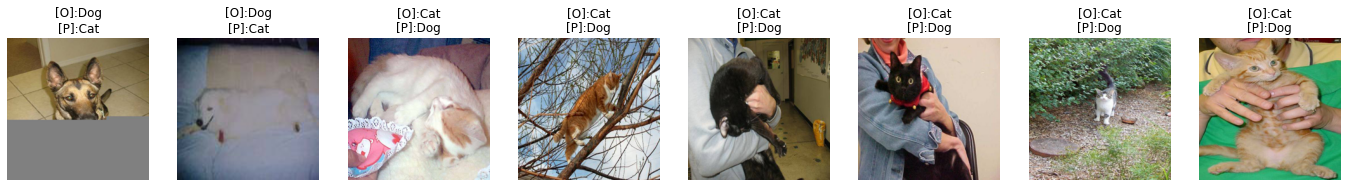

In [44]:
trans = ["Dog", "Cat"]
idx = np.nonzero(pre != y_test)[0]
pre_false_img = ori_imgs[idx]
pre_false_val = pre[idx]
pre_false_ori = y_test[idx]

plt.figure(figsize=(30, 30))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_false_ori[i]],
                                trans[pre_false_val[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i])

Enter:https://p6-tt.byteimg.com/origin/pgc-image/5ef74bab0f414354a7d2f51fa37dfe8d?from=pc


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


預測: Dog
機率: [0.99324363 0.00675636]


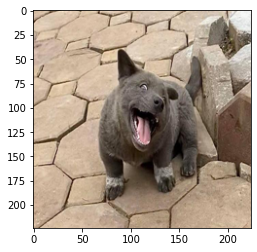

In [49]:
import requests
url = input("Enter:")
response = requests.get(url, stream=True, verify=False)
img = Image.open(response.raw).resize((224, 224)).convert("RGB")
img_np = preprocess_input(np.array(img).reshape(1, 224, 224, 3))
proba = model.predict(img_np)
ans = proba.argmax(axis=1)
print("預測:", trans[ans[0]])
print("機率:", proba[0])
plt.imshow(img)